## Computational Homework 7: The double descent phenomenon

In this assignment we will investigate an interesting and unexpected phenomenon that can occur when we fit non-linear functions using least squares called _double descent_. To do this, we will consider fitting a polynomial model to some simple synthetic data which is generated as follows:

$$
y_i = f_\star(x_i) + \varepsilon_i
$$

where $f_\star(x) = x^3 - x$, $x\in [-1,1]$, and $\varepsilon \sim N(0,\sigma^2)$ (here we use $\sigma^2 = 0.01$, but feel free to try this with other values of $\sigma$ as well). The following cell generates this dataset and plots it.

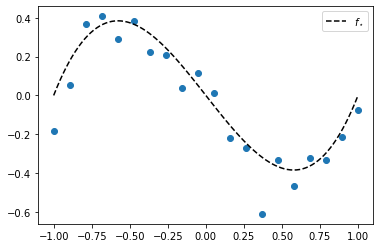

In [1]:
import numpy as np
import matplotlib.pyplot as plt

f_star = lambda x: x**3 - x

n = 20
sigma = 0.1
x = np.linspace(-1,1,n)
y = f_star(x) + sigma*np.random.normal(size=n)

x_test = np.linspace(-1,1,100)

plt.plot(x_test, f_star(x_test), color='black', linestyle='--', label="$f_\star$")
plt.scatter(x, y)
plt.legend()
plt.show()


For this assignment, we will experiment with fitting models to this data using feature maps of the form 

$$
\phi_p(x) = (P_0(x), P_1(x),\dots, P_{p-1}(x))
$$

where $P_j$ is the $j^{th}$ [Legendre polynomial](https://en.wikipedia.org/wiki/Legendre_polynomials). Legendre polynomials are a lot like normal polynomials, except they are designed to be _orthogonal_ in the sense that

$$
\int_{-1}^1 P_j(x)P_k(x)dx = 0
$$

for $j\neq k$. This property isn't particularly important for us, though Legendre polynomials are popular feature maps to use in practice, and so they are worth knowing of. Given an integer $p\geq 0$, we can use this feature map to define an $n\times (p+1)$ feature matrix

$$
X_p = \begin{bmatrix} P_0(x_1) & P_1(x_1) & \cdots & P_{p}(x_1)\\ \vdots & \vdots & \vdots &\vdots \\ P_0(x_n) & P_1(x_n) & \cdots & P_{p}(x_n)\end{bmatrix} \in \mathbb{R}^{n\times (p+1)}.
$$

This matrix can be constructed using the function `np.polynomial.legendre.legvander`, as we demonstrate in the following cell.

In [2]:
legendre_basis = np.polynomial.legendre.legvander

p = 4
u = np.array([1,2,3])
legendre_basis(u, p) # 3 x 5 matrix of features

array([[  1.   ,   1.   ,   1.   ,   1.   ,   1.   ],
       [  1.   ,   2.   ,   5.5  ,  17.   ,  55.375],
       [  1.   ,   3.   ,  13.   ,  63.   , 321.   ]])

Given coefficients $\beta = (\beta_0,\dots,\beta_{p-1}, \beta_p)$, we can use these polynomials to fit functions of the form 

$$
f(x) = \beta\cdot \phi(x) = \beta_0P_0(x) + \beta_1P_1(x) + \cdots \beta_{p-1}P_{p-1}(x) + \beta_p P_p(x).
$$

For example, we can plot the function $f(x) = P_0(x) - P_1(x) + P_2(x)$ using the following.

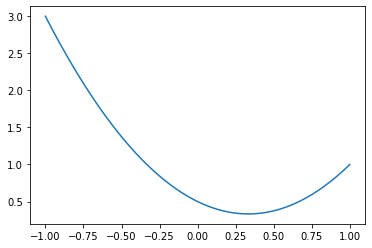

In [3]:
coef = np.array([1,-1, 1])
X = legendre_basis(x_test, 2)
plt.plot(x_test, np.dot(X,coef))
plt.show()

**Problem 1.** Write a function `fit_mp` which, for a feature matrix $X$, computes the Moore-Penrose fit $\hat{\beta}_{MP} = X^{\dagger}y$ where $X^\dagger$ is the pseudo-inverse of $X$. (Note: the function `np.linalg.pinv` should be used here). Use this to compute the least squares fits for $p = [1,2,\dots,12]$, and plot the MSE on the test set (i.e. $\frac{1}{n_{test}}\sum_{x_{test}} (f_\star(x_{test}) - \hat{f}(x_{test}))^2$) as a function of $p$. Describe in words what this plot looks like. If you had to use this plot to pick a value of $p$, which would you choose?

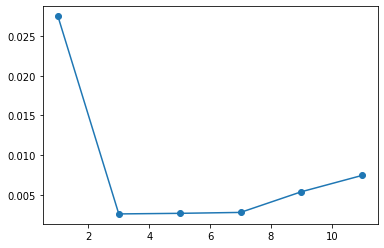

In [4]:
def fit_mp(X, y):
    return np.linalg.pinv(X)@y

p_range = np.arange(1,12,2)
errors = []

x_test = np.linspace(-1,1,100)
for p in p_range:
    Xp = legendre_basis(x, p)
    Xp_test = legendre_basis(x_test,p)
    beta_hat = fit_mp(Xp, y)
    f_hat = Xp_test@beta_hat
    errors.append(np.mean((f_star(x_test)-f_hat)**2))

plt.plot(p_range, errors, marker='o')
plt.show()

**Problem 2** Next, perform the same steps as problem 1, only for $p = 10,11,\dots,29,30$. Now what does the plot of MSE vs $p$ look like? What value of $p$ is best? Does this curve have a maximum? If so, at what value? How does this relate to the number of samples ($n=20$, in this case)? Next, plot the fitted functions $\hat{f}$ for $p=3,20,30$. Describe the behavior of these functions in words, and relate their behavior to their MSE's.

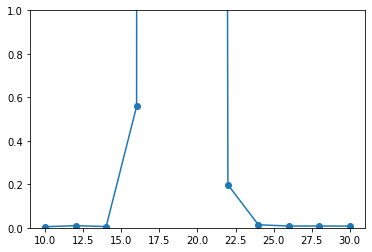

In [5]:
p_range = np.arange(10,32,2)
errors = []

x_test = np.linspace(-1,1,100)
f_test = f_star(x_test)
for p in p_range:
    Xp = legendre_basis(x, p)
    Xp_test = legendre_basis(x_test,p)
    beta_hat = fit_mp(Xp, y)
    f_hat = Xp_test@beta_hat
    errors.append(np.mean((f_test-f_hat)**2))

plt.plot(p_range, errors, marker='o')
plt.ylim(0,1)
plt.show()

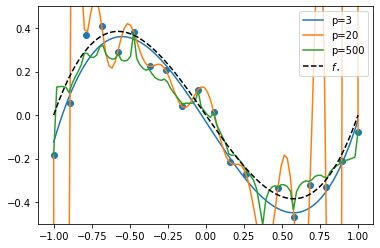

In [7]:
for p in [3, 20, 500]:
    Xp = legendre_basis(x, p)
    Xp_test = legendre_basis(x_test,p)
    beta_hat = fit_mp(Xp, y)
    f_hat = Xp_test@beta_hat
    plt.plot(x_test, f_hat, label=f"p={p}")

plt.plot(x_test, f_star(x_test), color='black', linestyle='--', label="$f_\star$")
plt.ylim(-.5,.5)
plt.scatter(x, y)
plt.legend()
plt.show()

**Problem 3.** In this problem, we show that phenomenon observed in Problem 2 goes away when we add Ridge regularization. To see this, for each value of $p = 1,2,\dots,29,30$, compute the Ridge estimator $\hat{\beta}_{RR}(\lambda) = (X_p^\top X_p + \lambda I)^{-1}X_p^\top y$ for $\lambda = 10$, and compute its MSE on the test examples `x_test`. What does the MSE plot look like now as a function of $p$? Describe its behavior in words.

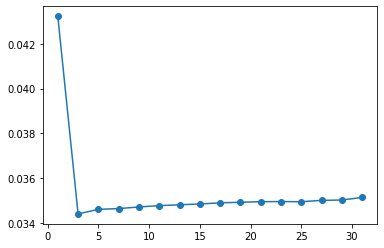

In [ ]:
def fit_ridge(X, y, lamb = 10.):
    return np.dot(np.linalg.inv(X.T@ X + lamb*np.eye(X.shape[1])), np.dot(X.T, y))

p_range = np.arange(1,32,2)
errors = []

x_test = np.linspace(-1,1,100)
f_test = f_star(x_test)
for p in p_range:
    Xp = legendre_basis(x, p)
    Xp_test = legendre_basis(x_test,p)
    beta_hat = fit_ridge(Xp, y)
    f_hat = Xp_test@beta_hat
    errors.append(np.mean((f_test-f_hat)**2))

plt.plot(p_range, errors, marker='o')
plt.show()